In [1]:
import numpy as np
import torch
import sklearn.datasets
import struct

from utils.preprocess import preprocess_data
from utils.loss import nll
from utils.helpers import generate_sign_patterns, get_out_string
from utils.cvxpy_model import cvxpy_solver
from utils.pytorch_model import sgd_solver
from utils.visualization import get_times_epoch_xaxis, plot_metrics_over_time, plot_all_models

## Load Data

In [2]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

directory = "all_data/mnist_data/"
mnist_data = read_idx(directory + 't10k-images-idx3-ubyte') > 0
num_train = 800
num_valid = 200
num_test = 1000
mdtrain = mnist_data[:num_train]
mdvalid = mnist_data[num_train : num_train + num_valid]
mdtest = mnist_data[num_train + num_valid : num_train + num_valid + num_test]
X_tr = mdtrain.reshape((num_train, -1))
X_v = mdvalid.reshape((num_valid, -1))
X_tst = mdtest.reshape((num_test, -1))
X_train, y_train, X_valid, y_valid, X_test, y_test, D = preprocess_data(X_tr, X_v, X_tst, r=10)

In [3]:
# generate random sign patterns
P, verbose = 50, True # SET verbose to True to see progress
sign_pattern_list, u_vector_list = generate_sign_patterns(X_train, P, verbose)
num_neurons = len(sign_pattern_list)
num_epochs, batch_size = 10, 100
beta_noncvx = 1e-3
learning_rate = 1e-3

Number of unique sign patterns generated: 50


## NN

In [4]:
solver_type = "sgd" # pick: "sgd" or "LBFGS"
LBFGS_param = [10, 4] # these parameters are for the LBFGS solver
results_noncvx = sgd_solver(X_train, y_train, X_valid, y_valid, 
                            num_epochs, num_neurons, beta_noncvx, 
                            learning_rate, batch_size, solver_type, 
                            LBFGS_param, D, verbose=verbose, eps=1e-2, 
                            last_n=10)

Epoch [0/10], TRAIN: nll: 348.306, loss: 348.39, acc: 0.878.
		TEST: nll: 457.852, loss: 457.852, acc: 0.911.
Epoch [1/10], TRAIN: nll: 326.153, loss: 326.25, acc: 0.89.
		TEST: nll: 429.041, loss: 429.041, acc: 0.933.
Epoch [2/10], TRAIN: nll: 320.137, loss: 320.241, acc: 0.891.
		TEST: nll: 418.721, loss: 418.721, acc: 0.935.
Epoch [3/10], TRAIN: nll: 317.423, loss: 317.531, acc: 0.891.
		TEST: nll: 412.415, loss: 412.415, acc: 0.935.
Epoch [4/10], TRAIN: nll: 316.032, loss: 316.144, acc: 0.891.
		TEST: nll: 409.592, loss: 409.592, acc: 0.935.
Epoch [5/10], TRAIN: nll: 315.39, loss: 315.506, acc: 0.891.
		TEST: nll: 405.375, loss: 405.375, acc: 0.935.
Epoch [6/10], TRAIN: nll: 314.833, loss: 314.951, acc: 0.891.
		TEST: nll: 407.305, loss: 407.305, acc: 0.935.
Epoch [7/10], TRAIN: nll: 314.555, loss: 314.674, acc: 0.891.
		TEST: nll: 407.391, loss: 407.391, acc: 0.935.
Epoch [8/10], TRAIN: nll: 314.326, loss: 314.447, acc: 0.891.
		TEST: nll: 406.928, loss: 406.928, acc: 0.935.
Epoch

## PyTorch - hinge loss

In [5]:
# SGD solver for the convex problem
beta_cvx = 2 * beta_noncvx
rho = 1e-4
solver_type = "sgd" # pick: "sgd" or "LBFGS"
LBFGS_param = [10, 4] # these parameters are for the LBFGS solver
learning_rate = 1e-3
results_pt_hinge = sgd_solver(X_train, y_train, X_valid, y_valid, 
                              num_epochs, num_neurons, beta_cvx,
                              learning_rate, batch_size, solver_type, 
                              LBFGS_param, D, rho=rho, convex=True,
                              u_vector_list=u_vector_list, verbose=verbose,
                              eps=1e-2, last_n=10)

Epoch [0/10], TRAIN: nll: 314.618, loss: 314.875, acc: 0.891.
		TEST: nll: 404.035, loss: 404.119, acc: 0.935.
Epoch [1/10], TRAIN: nll: 313.893, loss: 314.167, acc: 0.891.
		TEST: nll: 406.335, loss: 406.421, acc: 0.935.
Epoch [2/10], TRAIN: nll: 313.616, loss: 313.895, acc: 0.891.
		TEST: nll: 402.406, loss: 402.491, acc: 0.935.
Epoch [3/10], TRAIN: nll: 313.38, loss: 313.666, acc: 0.891.
		TEST: nll: 405.325, loss: 405.411, acc: 0.935.
Epoch [4/10], TRAIN: nll: 313.301, loss: 313.59, acc: 0.891.
		TEST: nll: 405.285, loss: 405.37, acc: 0.935.
Epoch [5/10], TRAIN: nll: 313.212, loss: 313.505, acc: 0.891.
		TEST: nll: 402.245, loss: 402.331, acc: 0.935.
Epoch [6/10], TRAIN: nll: 313.148, loss: 313.445, acc: 0.891.
		TEST: nll: 403.662, loss: 403.749, acc: 0.935.
Epoch [7/10], TRAIN: nll: 313.187, loss: 313.488, acc: 0.891.
		TEST: nll: 405.959, loss: 406.045, acc: 0.935.
Epoch [8/10], TRAIN: nll: 313.114, loss: 313.416, acc: 0.891.
		TEST: nll: 404.497, loss: 404.583, acc: 0.935.
Epoc

## PyTorch - relaxed

In [6]:
# SGD solver for the convex problem
beta_cvx = 2 * beta_noncvx
solver_type = "sgd" # pick: "sgd" or "LBFGS"
LBFGS_param = [10, 4] # these parameters are for the LBFGS solver
learning_rate = 1e-3
results_pt_relaxed = sgd_solver(X_train, y_train, X_valid, y_valid, 
                                num_epochs, num_neurons, beta_cvx,
                                learning_rate, batch_size, solver_type, 
                                LBFGS_param, D, rho=0, convex=True,
                                u_vector_list=u_vector_list, verbose=verbose, 
                                eps=1e-2, last_n=10)

Epoch [0/10], TRAIN: nll: 314.654, loss: 314.782, acc: 0.891.
		TEST: nll: 404.376, loss: 404.376, acc: 0.935.
Epoch [1/10], TRAIN: nll: 313.833, loss: 313.973, acc: 0.891.
		TEST: nll: 402.835, loss: 402.835, acc: 0.935.
Epoch [2/10], TRAIN: nll: 313.707, loss: 313.853, acc: 0.891.
		TEST: nll: 402.279, loss: 402.279, acc: 0.935.
Epoch [3/10], TRAIN: nll: 313.399, loss: 313.549, acc: 0.891.
		TEST: nll: 405.459, loss: 405.459, acc: 0.935.
Epoch [4/10], TRAIN: nll: 313.259, loss: 313.415, acc: 0.891.
		TEST: nll: 403.578, loss: 403.578, acc: 0.935.
Epoch [5/10], TRAIN: nll: 313.2, loss: 313.359, acc: 0.891.
		TEST: nll: 403.357, loss: 403.358, acc: 0.935.
Epoch [6/10], TRAIN: nll: 313.177, loss: 313.338, acc: 0.891.
		TEST: nll: 402.531, loss: 402.531, acc: 0.935.
Epoch [7/10], TRAIN: nll: 313.343, loss: 313.509, acc: 0.891.
		TEST: nll: 400.492, loss: 400.492, acc: 0.935.
Epoch [8/10], TRAIN: nll: 313.181, loss: 313.349, acc: 0.891.
		TEST: nll: 401.531, loss: 401.531, acc: 0.935.
Epo

## CVXPY - exact

In [8]:
# CVXPY solver for the convex problem
max_iters = 2000
solver_type = 'SCS' #'ECOS', 'OSQP', or 'SCS'
beta_cvx = 2 * beta_noncvx
batch_size = 10
results_cp_exact = cvxpy_solver(X_train, y_train, X_valid, y_valid, 
                                max_iters, num_neurons, beta_cvx, 
                                solver_type, D, u_vector_list, 
                                batch_size=batch_size, verbose=True)

created problem
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 87484
eps = 1.00e-04, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 1230, constraints m = 51370
Cones:	linear vars: 50210
	soc vars: 1100, soc blks: 100
	exp vars: 60, dual exp vars: 0
Setup time: 4.07e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.30e+19  1.32e+21  1.00e+00 -6.17e+20  2.02e+24  4.67e+24  1.14e-02 
   100| 6.25e-02  1.33e+00  7.58e-01  2.78e+02  2.02e+03  1.47e-13  8.11e-01 
   200| 1.30e-04  3.63e-03  3.16e-04  2.

## CVXPY - relaxed

In [9]:
# CVXPY solver for the convex problem
max_iters = 2000
solver_type = 'SCS' #'ECOS', 'OSQP', or 'SCS'
beta_cvx = 2 * beta_noncvx
#batch_size = 10000 #X_train.shape[0]
results_cp_relaxed = cvxpy_solver(X_train, y_train, X_valid, y_valid, 
                                  max_iters, num_neurons, beta_cvx, 
                                  solver_type, D, u_vector_list,
                                  batch_size=batch_size,
                                  exact=False, verbose=True)

created problem
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 2484
eps = 1.00e-04, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 1230, constraints m = 1370
Cones:	linear vars: 210
	soc vars: 1100, soc blks: 100
	exp vars: 60, dual exp vars: 0
Setup time: 5.96e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.02e+20  9.45e+20  1.00e+00 -2.16e+22  1.35e+24  1.02e+24  3.83e-03 
   100| 4.93e-04  1.25e-03  9.15e-04  2.70e+02  2.70e+02  1.47e-12  6.72e-02 
   200| 3.17e-04  9.26e-04  7.33e-04  2.70e+

## Visualization

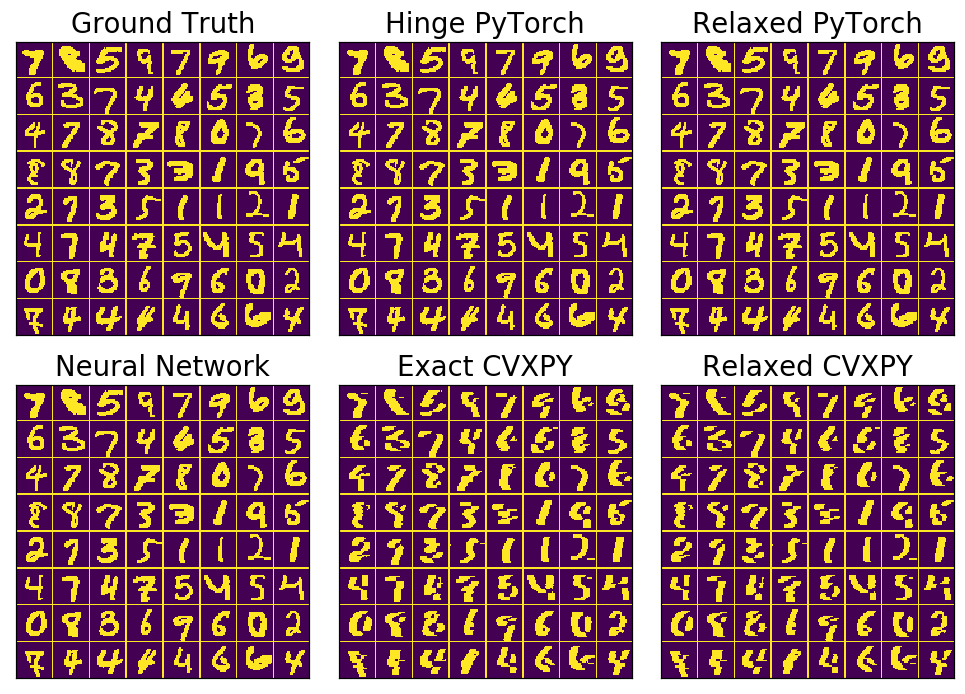

In [10]:
n = 64
start = 100
fontsize = 18
width = 11
scale = 16
models = [results_pt_hinge[-1], results_pt_relaxed[-1], results_noncvx[-1], 
          results_cp_exact[-1], results_cp_relaxed[-1]]
names = ['Hinge PyTorch', 'Relaxed PyTorch', 'Neural Network', 'Exact CVXPY', 'Relaxed CVXPY']
# plot_all_models(mdtrain, shifted, start, n, models, names, fontsize, width)
#plot_all_models(mdvalid, X_valid, start, n, models, names, fontsize, width)
plot_all_models(mdtest, X_test, start, n, models, names, fontsize, width, scale)

In [ ]:
times_nc, epoch_times_nc, xaxis_nc = get_times_epoch_xaxis(results_noncvx, num_epochs)
times_pth, epoch_times_pth, xaxis_pth = get_times_epoch_xaxis(results_pt_hinge, num_epochs)
times_ptr, epoch_times_ptr, xaxis_ptr = get_times_epoch_xaxis(results_pt_relaxed, num_epochs)
times_cpe, epoch_times_cpe, xaxis_cpe = get_times_epoch_xaxis(results_cp_exact, num_epochs, cvxpy=True)
times_cpr, epoch_times_cpr, xaxis_cpr = get_times_epoch_xaxis(results_cp_relaxed, num_epochs, cvxpy=True)

In [ ]:
plot_metrics_over_time(xaxis_pth=xaxis_pth, results_pt_hinge=results_pt_hinge)
plot_metrics_over_time(xaxis_ptr=xaxis_ptr, results_pt_relaxed=results_pt_relaxed)
plot_metrics_over_time(xaxis_nc=xaxis_nc, results_noncvx=results_noncvx)